In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf

import TA_utils as ta

# if os.getcwd().split("\\")[-1] == "midter":
#     os.chdir("../")

# current_dir = os.getcwd()
# if current_dir[-16:] == "midterm_practice":
#     parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
#     parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    
#     os.chdir(parent_dir)
#     sys.path.insert(0, parent_dir)
# import cmds.portfolio_management_helper as pmh

# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

In [351]:
file_path = r"midterm_1_data.xlsx"
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

# ticker_mapping = {tick: name 
#                   for tick, name in zip(dfs_raw['info'].iloc[:, 0], 
#                                                 dfs_raw['info'].iloc[:, 1])}
# ticker_mapping

stocks excess returns: (148, 15)
proshares excess returns: (158, 10)
fx carry returns: (1305, 6)


## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

**TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.**
If TIPS was found to be uncorrelated to SPY and IEF, it would likely have low correlation to the other assets as well. This would make it a very appealing asset to invest in, allowing more diversification.
So TIPS would likely have a higher weight in the MV solution and would likely reduce the overall risk of the portfolio.

**TIPS is found to have correlation of 100% to `IEF`.**

If TIPS is found to have a 100% correlation with IEF, there would be computational issues in our problem. Our covariance matrix would be singular and we would not be able to solve for the weights.

**Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? **

Very unlikely in practice. The payoff of a TIPS is very similar to a bond. When inflation is small, the cashflows from a TIPS are very similar to a bond. If the pay offs of the instrument are very similar, they must have the same return. Finally have have seen periods of low inflation, therefore we must have seen periods where the returns from TIPS are similar to the returns of bonds.

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

In linear factor decomposition, you wish to explain an asset's return using a linear combination of other factors. The intercept tells you how much return that asset gets, ignoring the other factors.

Not including an intercept
- **Wish to recreate the portfolio.** Performing LDF onto other assets can tell you how to recreate the portfolio. You should not include an intercept because there is no asset which gives constant return

Including an intercept
- **Estimate alpha** If you want to estimate the alpha of the asset, you should include the intercept.
- **Hard to estimate** The mean of a return is very hard to estimate. By including the intercept, you can take away this uncertainty in the mean. This will give you better beta values.
- **Factors are not good predictors** By including the intercept, we account for the fact that the factors are not good predictors of the future returns. This alpha says how much of the return is not being explained by the factors.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

In [352]:
df_excess_rets = dfs_raw['stocks excess returns'].copy().set_index("date")
annual_factor = 12

print(f"{min(df_excess_rets.index)} - {max(df_excess_rets.index)}")
display(df_excess_rets.head())

2012-06-30 00:00:00 - 2024-09-30 00:00:00


,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2012-06-30,0.010943,0.072609,0.050116,-0.001270,0.082263,0.077918,0.047953,0.050766,0.048052,0.111916,0.060768,0.052919,0.073267,0.088352
2012-07-31,0.045822,0.021677,0.018121,0.091196,0.024570,0.015958,0.026101,-0.301929,-0.036613,-0.020260,-0.123682,-0.126667,0.044002,0.014958
2012-08-31,0.093695,0.063985,-0.006075,0.082161,-0.017188,0.031486,0.031399,-0.168306,0.052556,0.036008,0.039935,0.062649,-0.004849,0.011533
2012-09-30,0.002878,0.024450,0.045849,0.101397,0.022030,0.090012,0.055749,0.199417,-0.034312,-0.049099,0.026730,0.024657,0.047099,0.047619
2012-10-31,-0.107527,-0.084192,-0.020903,-0.098271,0.027789,0.037321,0.025805,-0.025320,-0.040922,-0.101877,-0.039204,0.010720,0.033436,-0.002989


### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [353]:
def calc_summary(df, annual_factor=1):
    return df.apply(lambda x: pd.Series({
        "mean": x.mean() * annual_factor,
        "std": x.std() * np.sqrt(annual_factor),
        "sharpe": x.mean() / x.std() * np.sqrt(annual_factor)  
    }))

def compute_stats(weights, mu_hat, sigma_hat, annual_factor=12):
    p_return = weights.T @ mu_hat * annual_factor
    p_vol = np.sqrt(weights.T @ sigma_hat @ weights) * np.sqrt(annual_factor)
    return p_vol, p_return

def tangent_portfolio(mu_hat, sigma_hat, flip_weights=False, annual_factor=12):
    sigma_inv = np.linalg.inv(sigma_hat)
    weights = sigma_inv @ mu_hat
    weights = weights / np.sum(weights)
    
    t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    if t_return < 0 and flip_weights:
        weights *= -1
        t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    return [t_vol, t_return, weights]

def create_portfolios(df_returns, annual_factor=annual_factor):
    mu_hat=df_returns.mean().values
    sigma_hat=df_returns.cov().values
    
    port_weights = {
        'Tangent': tangent_portfolio(mu_hat, sigma_hat, annual_factor=annual_factor)[2],
        # 'Equally-weighting': np.ones_like(mu_hat)/len(mu_hat),
        'Regularized': tangent_portfolio(mu_hat, 
                                         (sigma_hat + np.diag(np.diagonal(sigma_hat)) ) / 2
                                         )[2],
    }
    
    # Returns
    df_port_returns = pd.DataFrame({name : df_returns @ weights 
                                         for name, weights in port_weights.items()})
    
    # Statistics
    df_port_stats = calc_summary(df_port_returns, annual_factor=annual_factor)
    for name, weights in port_weights.items():
        df_port_stats.loc["sum weights", name] = sum(weights)
    df_port_weights = pd.DataFrame(port_weights, index=df_returns.columns)
        
    return df_port_weights, df_port_returns, df_port_stats


df_training = df_excess_rets[df_excess_rets.index <= "20181231"]

df_port_weights, df_port_returns, df_port_stats = create_portfolios(df_training)
display(df_port_weights)

print(f"Abs sum of weights for tangent: {df_port_weights['Tangent'].abs().sum():.2f}")
print(f"Abs sum of weights for Regularized: {df_port_weights['Regularized'].abs().sum():.2f}")

,Tangent,Regularized
AAPL,-0.127836,-0.014706
AMZN,-0.040576,0.036310
BRK-B,0.131333,0.109162
GOOGL,0.025968,0.050545
JNJ,0.130408,0.099190
JPM,-0.013929,0.053691
LLY,0.352670,0.214949
META,0.030541,0.034896
MSFT,0.137917,0.089970
NVDA,0.163501,0.071696


Abs sum of weights for tangent: 2.20
Abs sum of weights for Regularized: 1.34


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [354]:
calc_summary(df_training @ df_port_weights,  annual_factor=annual_factor)

,Tangent,Regularized
mean,0.348256,0.276599
std,0.134053,0.114184
sharpe,2.597896,2.422392


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [355]:
df_testing = df_excess_rets[df_excess_rets.index > "20181231"]

(
    df_testing @ df_port_weights 
).tail(3)

,Tangent,Regularized
date,,
2024-07-31,-0.016012,0.003227
2024-08-31,0.101241,0.064626
2024-09-30,-0.025162,-0.016477


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [356]:
calc_summary(df_testing @ df_port_weights,  annual_factor=annual_factor)

,Tangent,Regularized
mean,0.321558,0.268686
std,0.222352,0.176334
sharpe,1.446167,1.523729


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

The annualized sharpe ratio is 1.52 for the 'regularized' portfolio and 1.46 for the 'tangent' portfolio. The regularized portfolio has a better risk-return profile in the out-of-sample.

The regularized portfolio assumes less correlation between assets, so the weights are more spread out.
This can be seen in the abs sum weights for the regularized portfolio being lower than the abs sum weights for the tangent portfolio. With the weights being more spread out, the portfolio is more diversified which can be one reason why it had a better risk-return profile in the out-of-sample.
 

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

In [357]:
df_proshares = dfs_raw['proshares excess returns'].copy().set_index("date")

df_proshares.columns = [x.replace(" US Equity", "") for x in df_proshares.columns]

display(df_proshares.head())

,HDG,QAI,SPY,EEM,EFA,EUO,IWM,SPXU,UPRO
date,,,,,,,,,
2011-08-31,-0.027036,-0.006489,-0.054976,-0.092549,-0.087549,-0.005889,-0.088913,0.056476,-0.210854
2011-09-30,-0.032466,-0.022141,-0.069420,-0.179063,-0.108082,0.142180,-0.111505,0.190006,-0.207003
2011-10-31,0.050531,0.025239,0.109147,0.162986,0.096274,-0.069502,0.151011,-0.298828,0.326066
2011-11-30,-0.028608,-0.007964,-0.004064,-0.019724,-0.021765,0.054627,-0.003784,-0.035515,-0.033502
2011-12-31,0.012875,0.001822,0.010449,-0.042649,-0.021744,0.075581,0.005144,-0.051986,0.022939


### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [358]:
regr = ta.calc_multivariate_regression(df_proshares['HDG'], 
                                       df_proshares[["QAI", "SPY", "EEM", "UPRO", "SPXU", "IWM", "EFA"]], 
                                       intercept=False,
                                       adj=annual_factor)

betas = regr.loc[:, regr.columns.str.contains('Beta')].T

exposure = betas * -1_000_000
exposure.index = exposure.index.str.replace('Beta', '')

exposure.style.format('${:,.0f}')

c:\Users\Frank Reynolds\OneDrive\Main\Classes\UChicago\FINM 36700 - Port and Risk\git_finm-portfolio-2024\exams\midterm1\TA_utils.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[f"{col} Beta"] = betas[i]


,HDG
QAI,"$-166,629"
SPY,"$-240,419"
EEM,"$-44,877"
UPRO,"$69,393"
SPXU,"$-16,065"
IWM,"$-139,894"
EFA,"$-120,177"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [359]:
print(f"R-squared: {regr['R-Squared'].values[0]:.2f}")
print(f"Gross Notional Exposure: ${exposure.sum().values[0]:,.0f}")

R-squared: 0.91
Gross Notional Exposure: $-658,669


**What do these two statistics indicate about the practical use of this hedge?**

With a gross notional of -$0.66mm, the magnitude of the hedge is half as large as the main position, and we are short this amount. This is very impractical since its highly levered.

The R-squared of the hedge is 0.91, which indicates that the hedge is very effective at hedging the position.

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [360]:
regr_fit = ta.calc_multivariate_regression(df_proshares['HDG'], 
                                           df_proshares[["QAI", "SPY", "EEM"]], 
                                           intercept=False,
                                           adj=annual_factor)
df_temp = pd.DataFrame()

df_temp["betas"] = regr_fit.loc[:, regr_fit.columns.str.contains('Beta')].T

df_temp.index = df_temp.index.str.replace('Beta', '')
display(df_temp)

c:\Users\Frank Reynolds\OneDrive\Main\Classes\UChicago\FINM 36700 - Port and Risk\git_finm-portfolio-2024\exams\midterm1\TA_utils.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[f"{col} Beta"] = betas[i]


,betas
QAI,0.356368
SPY,0.162696
EEM,0.086523


In [361]:
display((df_proshares[["QAI", "SPY", "EEM"]] @ df_temp["betas"].values).tail(3))

date
2024-07-31    0.006721
2024-08-31    0.007373
2024-09-30    0.013569
dtype: float64

### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [362]:
df_strategy = pd.DataFrame()
df_strategy["basket"] = df_proshares[["QAI", "SPY", "EEM"]] @ df_temp["betas"].values
df_strategy["HDG"] = df_proshares["HDG"]
df_strategy["epsilon"] = df_strategy["HDG"] - df_strategy["basket"]


df_strategy["strategy"] = 0
for i, date in enumerate(df_strategy.index):
    if i == 0:
        continue
    
    if df_strategy["epsilon"].iloc[i-1] <= 0:
        # - if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
        df_strategy.loc[date, "strategy"] = 2 * df_strategy.loc[date, "HDG"] - df_strategy.loc[date, "basket"]
    else:
        # - if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.
        df_strategy.loc[date, "strategy"] = 2 * df_strategy.loc[date, "basket"] - df_strategy.loc[date, "HDG"]

display(df_strategy.head())

C:\Users\Frank Reynolds\AppData\Local\Temp\ipykernel_18352\2569745039.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.030254664344383078' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy.loc[date, "strategy"] = 2 * df_strategy.loc[date, "HDG"] - df_strategy.loc[date, "basket"]


,basket,HDG,epsilon,strategy
date,,,,
2011-08-31,-0.019264,-0.027036,-0.007771,0.000000
2011-09-30,-0.034678,-0.032466,0.002212,-0.030255
2011-10-31,0.040854,0.050531,0.009677,0.031177
2011-11-30,-0.005206,-0.028608,-0.023402,0.018196
2011-12-31,-0.001341,0.012875,0.014215,0.027090


In [363]:
# Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

calc_summary(df_strategy[["strategy"]], annual_factor=annual_factor)

,strategy
mean,0.036563
std,0.062051
sharpe,0.589240


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [364]:
other_etfs = df_proshares.columns.difference(["QAI"])

regr_qai = ta.calc_multivariate_regression(df_proshares['QAI'], 
                                           df_proshares[other_etfs], 
                                           intercept=False,
                                           adj=annual_factor)
df_temp = pd.DataFrame()

df_temp["betas"] = regr_qai.loc[:, regr_qai.columns.str.contains('Beta')].T

df_temp.index = df_temp.index.str.replace('Beta', '')
display(df_temp)

c:\Users\Frank Reynolds\OneDrive\Main\Classes\UChicago\FINM 36700 - Port and Risk\git_finm-portfolio-2024\exams\midterm1\TA_utils.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[f"{col} Beta"] = betas[i]


,betas
EEM,0.046704
EFA,0.031268
EUO,-0.022726
HDG,0.246974
IWM,-0.001393
SPXU,0.043001
SPY,0.424617
UPRO,-0.058021


In [365]:
print(f"Sum of betas: {df_temp['betas'].abs().sum():.2f}")
print(f"Alpha: {regr_qai['Alpha'].values[0]:.2f}")
print(f"Information Ratio: {regr_qai['Information Ratio'].values[0]:.2f}")
print(f"R-squared: {regr_qai['R-Squared'].values[0]:.2f}")

Sum of betas: 0.87
Alpha: 0.00
Information Ratio: 0.00
R-squared: 0.84


<Axes: >

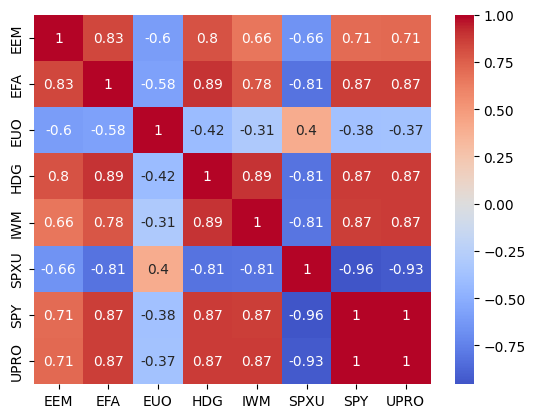

In [366]:
sns.heatmap(df_proshares[other_etfs].corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

* With a abs sum of beta of around 1, the replication is very good. This tells us all our betas a reasonable
* With an alpha of 0, this tells us there is little return not explained by the ETFS
* With an information ratio of 0, this tells us that there is no excess return in the portfolio
* With an R-squared of 0.84, this tells us that the ETFs we have chosen are good predictors of the QAI

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

In [367]:
df_fx = dfs_raw['fx carry returns'].copy().set_index("date")
df_fx = df_fx[["JPY"]]
annual_factor = 252

display(df_fx.head(10))

,JPY
date,
2019-01-07,-0.001843
2019-01-08,-0.000324
2019-01-09,0.005222
2019-01-10,-0.002486
2019-01-11,-0.000865
2019-01-15,-0.001843
2019-01-16,-0.003694
2019-01-17,-0.001635
2019-01-18,-0.004914


### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [368]:
percent_var = .01
df_jpy_vars = pd.DataFrame()

df_jpy_vars["empirical"] = (
    df_fx.shift(1)
    .expanding()
    .quantile(percent_var)
    )

display(df_jpy_vars.tail(1)[["empirical"]])

,empirical
date,
2024-08-05,-0.017182


### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [369]:
var_multiplier = -2.33
window = 233

df_jpy_vars["rolling_normal"] = (
    df_fx
    .rolling(window=window)
    .apply(lambda x: np.sqrt(sum(x**2)/len(x)))
    .shift(1) 
    * var_multiplier
)

display(df_jpy_vars.tail(3)[["rolling_normal"]])

,rolling_normal
date,
2024-08-01,-0.013350
2024-08-02,-0.013359
2024-08-05,-0.013631


### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [370]:
# def calc_ewma_volatility(excess_returns: pd.Series, theta : float = 0.94, initial_vol : float = .2 / np.sqrt(252)) -> pd.Series:
#     var_t0 = initial_vol ** 2
#     ewma_var = [var_t0]
#     for i in range(len(excess_returns.index)):
#         new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
#         ewma_var.append(new_ewma_var)
#     ewma_var.pop(0) # Remove var_t0
#     ewma_vol = [np.sqrt(v) for v in ewma_var]
#     return pd.Series(ewma_vol, index=excess_returns.index)

exp_lambda = .94

# # todo double check
# df_jpy_vars["ewma"] = calc_ewma_volatility(df_fx["JPY"], 
#                                            theta=exp_lambda, 
#                                            initial_vol=.2 / np.sqrt(252)
#                                            )



# np.sqrt((retsx['TSLA']**2).rolling(52).mean().shift())
df_jpy_vars["ewma"] = (
    np.sqrt((df_fx**2))
    .ewm(alpha=1-exp_lambda)
    .mean() 
    #.apply(lambda x: np.sqrt(sum(x**2)/len(x)))
    .shift(1) 
    * var_multiplier
)



# df_jpy_vars["ewma"] = (
#     df_fx
#     .ewm(alpha=1-exp_lambda) # todo check
#     .std() 
#     #.apply(lambda x: np.sqrt(sum(x**2)/len(x)))
#     .shift(1) 
#     * var_multiplier
# )

display(df_jpy_vars.tail(3)[["ewma"]])

,ewma
date,
2024-08-01,-0.012893
2024-08-02,-0.012676
2024-08-05,-0.014599


### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

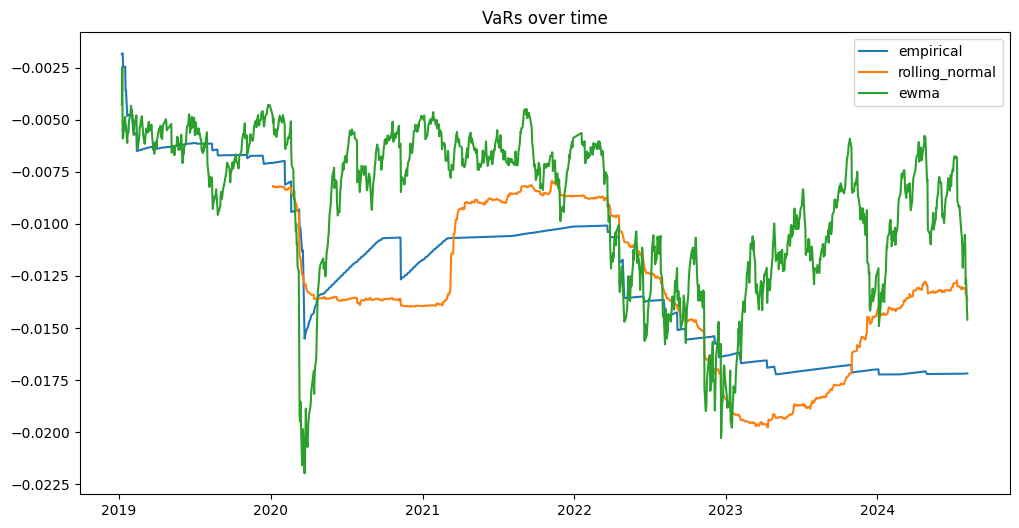

In [371]:
plt.figure(figsize=(12, 6))
for c in df_jpy_vars.columns:
    plt.plot(df_jpy_vars[c], label=c)

plt.legend()
plt.title("VaRs over time")
plt.show()

- The empiracl and rolling look pretty good. They are similar curves. 
- The ewma is not very smooth and has a drastic drop around 2020.

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

We use the the "hit percent" to judge the performance of a VaR model. Basically we look at
percentage of returns that exceed the VaR at the time. This percentage should be around 1% since we 
are estimating the 1% VaR

In [372]:
def get_hit_percent(cvars, returns):
    return sum(returns < cvars) / sum(~cvars.isna())


for c in df_jpy_vars.columns:
    print(f"Hit ratio for {c}: {get_hit_percent(df_jpy_vars[c], df_fx['JPY']):.5f}")

Hit ratio for empirical: 0.02454
Hit ratio for rolling_normal: 0.02519
Hit ratio for ewma: 0.05138


The hit ratios are a little large, especially for ewma. I prefer the empiracal approach because this has the hit percentage closest to 1%.

***